In [ ]:
# 먼저 완전한 방전 전압 곡선을 사용해서 모델을 학습

In [ ]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob
from torch.optim.lr_scheduler import StepLR

In [ ]:
path = os.getcwd()
print(path)

D:\Research\Battery SOH\Code


In [ ]:
def load_csvs(csv_paths):
    ## 파일에 있는 데이터들을 전치리 한후에 모두 다 병합
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path) #assert는 os에 해당 path가 존재하지 않으면 AssertError를 발생한다.
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10]
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        df = df[df["Voltage"] <3.21] # data reduction part -> 데이터의 특징을 더 잘나타낼 수 있는 부분 선택
        df = df[df["Voltage"] >2.95] # 학습시킬 voltage segment구간
        df["Charge_Capacity"] /= 1.1 # 공칙용량으로 나눠줌 >> 즉 charge_capcity를 퍼센트로 확인 가능
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique() # 각 파일당 사이클 횟수 저장
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [ ]:
def plot_cycles(data, cycles):
    print("plotting...")
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            try: #동일한 시작점으로 맞춰주는 과정
                time = time - time[0] 
            except:
                print (time, voltage, "skipping")
                continue
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()

In [ ]:
def fit_spline(data, cycles, no_points=500): # no_points 구간별 point 개수
    i = 0
    
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Charge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            
            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage, k=1) # class 반환

            # creating linear space 0, 200 of 20,000 points >> 0에서 700사이의 20000개의 일정한 간격의 요소를 만듬
            xi = np.linspace(0,700, 20000)
            yi_test = ius(xi) # 불연속인 y값을 대체할 yi_test값 생성

            index_1 = np.argmin(np.abs(yi_test[:1000] - 3.2)) #argmin 최솟값 위치 색인 
            index_2 = np.argmin(np.abs(yi_test - 3)) # 원래 3

            indices = np.linspace(index_1, index_2, no_points).astype(int)

            #discarding points that are greater than time
#             xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
#             indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)
#             #selecting time at specified indices
            xi = xi[indices]
            yi = ius(xi)
            if yi[yi<2.998].any():
                continue
# 각 변수별 일차원 배열을 생성해주는 과정                       
            ind = np.zeros_like(xi) + ind.values[0] #ind = step_time
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append(np.array([xi, yi, capacity, ind])) # 리스트에 합침
        cell_np = np.concatenate(cell_np, axis=1) 
        cell_np = np.transpose(cell_np, (1,0)) 
        data[i] = pd.DataFrame(cell_np, columns = ['Step_Time', 'Voltage', 'Charge_Capacity', 'Cycle_Index']) # 데이터 프레임화
        i+=1
        
    return data

In [ ]:
# mit_csv have pathes of all csv files in raw_mit file(즉 방전상태 뿐만아니라 충전과정 까지 포함한 데이터) > 총 10개의 모집단
mit_csvs = glob("D:\\Research\\Battery SOH\\DATA\\MIT discharge data\\*csv*")
#glob("./Capacity_data/MIT/*")
for csv in mit_csvs:
    print (csv)
# b1이 들어간 파일은 mit_csv리스트에 담지 않는다
mit_csvs = [i for i in mit_csvs if "b1c21" not in i]


D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_5_4C-60per_3C_CH16_b1c15_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_5_4C-80per_5_4C_CH11_b1c21_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_5_4C-80per_5_4C_CH12_b1c20_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-40per_3C_CH25_b1c24_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv
D:\Research\Battery SOH\DATA\MIT discharge data\2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv
D:\Research\Battery SOH\DATA\MIT discharge data\b1c1corrected.csv
D:\Research\Battery SOH\DATA\MIT discharge da

In [2]:
mit_csvs[:4]

NameError: ignored

170
total points in D:\Research\Battery SOH\DATA/MIT discharge data/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (44343, 8)
plotting...


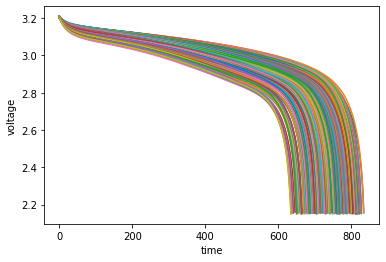

In [ ]:
# reducted discharge voltage curve(data after reduction)
test_csvs = glob("D:\\Research\\Battery SOH\\DATA/MIT discharge data/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv")
test_csvs, test_cycles = load_csvs(test_csvs)
plot_cycles(test_csvs, test_cycles)

In [ ]:
# reducted entire voltage curve
mit_data, mit_cycles = load_csvs(mit_csvs)
# plot_cycles(mit_data, mit_cycles)

717
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_5_4C-60per_3C_CH16_b1c15_discharge.csv (126438, 8)
532
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_5_4C-80per_5_4C_CH12_b1c20_discharge.csv (87902, 8)
1015
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-40per_3C_CH25_b1c24_discharge.csv (179120, 8)
852
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv (150032, 8)
840
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv (147570, 8)
874
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (154958, 8)
700
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv (121399, 12)
170
total points in D:\Research\Battery SOH\DATA\MIT discharge data\2017-06-30_2C

NameError: ignored

# Test csvs로 test_data만들어주는 과정

In [ ]:
# reducted discharge voltage curve(data after reduction)
test_csvs = [
'D:\\Research\\Battery SOH\\DATA/MIT discharge data\\2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv' ]
#  'D:\\Research\\Battery SOH\\DATA/MIT discharge data\\2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv' ]
# 'D:\\Research\\Battery SOH\\DATA/MIT discharge data\\2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv' ]
# 'D:\\Research\\Battery SOH\\DATA/MIT discharge data\\b1c1corrected.csv' ]
# 'D:\\Research\\Battery SOH\\DATA/MIT discharge data\\b1c2corrected.csv']


test_csvs

['D:\\Research\\Battery SOH\\DATA/MIT discharge data\\2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv']

874
total points in D:\Research\Battery SOH\DATA/MIT discharge data\2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (154958, 8)
plotting...


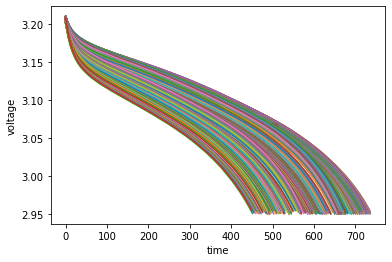

In [ ]:
test_csvs, test_cycles = load_csvs(test_csvs)
plot_cycles(test_csvs, test_cycles)

plotting...


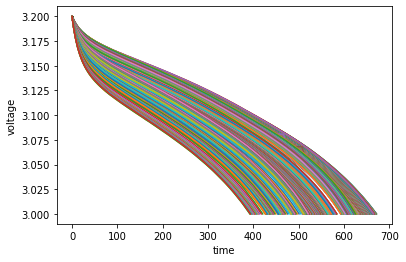

In [ ]:
test_data = fit_spline(test_csvs.copy(), test_cycles, no_points=500)
plot_cycles(test_data, test_cycles)

In [ ]:
# 모든 셀의 데이터를 fit spline함수 진행.
mit_d = fit_spline(mit_data.copy(), mit_cycles, no_points=500)

In [ ]:
len(mit_d)

10

plotting...


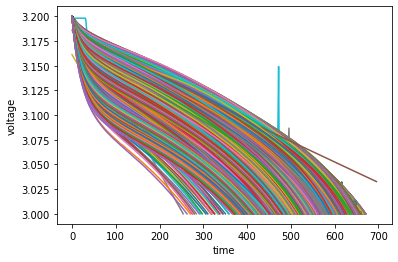

In [ ]:
plot_cycles(mit_d, mit_cycles)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


    
# creating a four layer neural network.
# number of elements in input layer = segment length x 2
# 2 hidden layers each with two hundred units

    
# Neural Net to predict capacity # 다층 신경망 구조
class CapacityNet(nn.Module):
    def __init__(self):
        super(CapacityNet, self).__init__()

        self.l1 = nn.Linear(in_features= int(500 * 2), out_features=400) # 입력차원 1000, 출력 400
        self.l2 = nn.Linear(in_features=400, out_features=400) # 입력차원 400, 출력 400
        self.l3 = nn.Linear(in_features=400, out_features=400) # 입력차원 400, 출력 400
        self.l4 = nn.Linear(in_features=400, out_features=200) # 입력차원 400, 출력 200
        self.l5 = nn.Linear(in_features=200, out_features=100) # 입력차원 200, 출력 100
        self.l6 = nn.Linear(in_features=100, out_features=1) # 입력차원 100, 출력 1
        
    def forward(self, x):
        x = F.relu(self.l1(x)) # reLu 
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        return self.l6(x)

    

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from bisect import bisect
  

# procesing data to get samples for training and testing
# minibatch gradient descnet 사용    
class CapacityDataset(Dataset):
    def __init__(self, data, type="train"):
        self.cycles = []

        for d in data:
            self.cycles.append(d.Cycle_Index.unique())
        self.data = data
#         self.window = window
        # cycles per cell
        self.spc = [cycle.shape[0] for cycle in  self.cycles]
        
    def __len__(self):
        return sum(self.spc)

    def __getitem__(self, idx):
        
        # the next three lines are locating the index in cycles of a particular cell
        
        cumsum = np.cumsum(self.spc)
        cell_no = bisect(cumsum, idx)
        ind = idx if cell_no == 0 else idx - cumsum[cell_no - 1]
        
        # picking the value of time, voltage, and capacity for the specified cycle during training or testing
        
        time_step = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Step_Time.values
        voltage = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Voltage.values
        capacity = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Charge_Capacity.max()
        
        # choosing a segment of specified length from the discharge curve for training or testing
        # if random = True, the segment will start anywhere from start of curve to 400- length of segment
#         print (time_step.shape, voltage.shape, cell_no, ind, capacity )

#         segment_length = np.random.randint(self.window[0], self.window[1])
#         start = 0 if not self.random else np.random.randint(0, 400 - segment_length)
#         time_x = time_step[start: start+segment_length]
#         voltage_x = voltage[start: start+segment_length]
        # creating input / feature vector (segment length x2)
        # the vector has voltage values followed by the corresponding time values
#         x = np.zeros((voltage_x.shape[0]*2))
        x = np.zeros((voltage.shape[0]*2))
#         max_segment = np.zeros((self.max_points * 2)) 
        x[::2] = voltage
        x[1::2] = time_step / 100
#         x_random_seg = np.zeros(((self.window[1] - 1) * 2))
#         x_random_seg[:x.shape[0]] = x

#         max_segment[:x.shape[0]] = x


        return x , torch.from_numpy(np.array([capacity]))


In [ ]:
train_voltage_c = CapacityDataset(mit_d[:4]) # 보충자료에 의한 학습 입력 데이터로 바꿔주었다. 원래는 :5 였음
train_loader_c = DataLoader(train_voltage_c, batch_size=64, shuffle=True) # batch_size 64개 

# valid와 test는 한개의 데이터 셋으로 진행되므로 shuffle이 false여도 상관 없다.
valid_voltage_c = CapacityDataset([mit_d[4]])
valid_loader_c = DataLoader(valid_voltage_c, batch_size=64, shuffle=False) 

test_mit = CapacityDataset(test_data)
test_loader_mit = DataLoader(test_mit, batch_size=64, shuffle=False)

# Net to predict Capacity
net =  CapacityNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.000561) # optimizer로 adam을 사용하며 학습률은 0.000561이다.
criteria = torch.nn.MSELoss() # loss function : MSE
scheduler = StepLR(optimizer, step_size=4, gamma=0.99)


def train(net, best, train_set, test_set, optimizer, criteria, epoch, best_mape):
    for dset, mode in [(train_set, 'train'), (test_set, 'test')]: # looping over two dataloaders (train and test)
        if mode == "test":
            net.eval() # if testing, don't compute gradients 
        else:
            net.train()
        loss = 0
        preds = []
        target = []
        for ind, (x, y) in enumerate(dset): # looping over dataloader (train or test)
            x = x.float()  #converting datatype to float, data type of inputs must match the datatype of weights of network
            y = y.float()

            pred = net(x) # neural net forward is called with input x. it will return capacity
            loss = criteria(pred, y) # computing mean square error between predicted capacity and target capacity
#             print (mode)
            if mode == "test":
                preds.extend(pred.detach().numpy().reshape(-1)) # if test dataloader, save the predictions for further analysis
                target.extend(y.cpu().numpy())
            if mode == 'train':
                optimizer.zero_grad() # if train mode, if there are any gradients from previous time step, set them to 0
                loss.backward()  # back propagation
                optimizer.step() # updating the weights
            loss += loss.item()  # converting loss(pytorch tensor) to python object and adding the value to total loss
    
    mape =  mean_absolute_percentage_error(preds, target) # computing the error of epoch
    if mape < best_mape and mode == "test":
        best = copy.deepcopy(net) #if error is less than the best error observed so far. save the model
        best_mape = mape # current error is the least error so for. so setting it as the best mape
    print (f'Mode: {mode} __ Epoch: {epoch} __ Loss: {loss/len(dset)}, mape: {mape}, Best Mape: {best_mape}')
    return net, best, best_mape # return the trained net

In [ ]:
best_mape=4
best=None
for epoch in range(100):
    net, best, best_mape = train(net, best, train_loader_c, valid_loader_c, optimizer, criteria, epoch, best_mape)
    print (f'Learning rate {scheduler.get_last_lr()}')
    scheduler.step()
    

Mode: test __ Epoch: 0 __ Loss: 7.624785212101415e-06, mape: 0.025293339043855667, Best Mape: 0.025293339043855667
Learning rate [0.000561]
Mode: test __ Epoch: 1 __ Loss: 2.4732684323680587e-05, mape: 0.011920472607016563, Best Mape: 0.011920472607016563
Learning rate [0.000561]
Mode: test __ Epoch: 2 __ Loss: 2.997094634338282e-05, mape: 0.012779932469129562, Best Mape: 0.011920472607016563
Learning rate [0.000561]
Mode: test __ Epoch: 3 __ Loss: 4.51205087301787e-05, mape: 0.012410699389874935, Best Mape: 0.011920472607016563
Learning rate [0.000561]
Mode: test __ Epoch: 4 __ Loss: 6.057123391656205e-05, mape: 0.012112116441130638, Best Mape: 0.011920472607016563
Learning rate [0.00055539]
Mode: test __ Epoch: 5 __ Loss: 5.712182246497832e-05, mape: 0.013284140266478062, Best Mape: 0.011920472607016563
Learning rate [0.00055539]
Mode: test __ Epoch: 6 __ Loss: 8.582628652220592e-05, mape: 0.011405347846448421, Best Mape: 0.011405347846448421
Learning rate [0.00055539]
Mode: test __ 

Mode: test __ Epoch: 55 __ Loss: 9.47404041653499e-05, mape: 0.008534379303455353, Best Mape: 0.007997739128768444
Learning rate [0.0004922892939024209]
Mode: test __ Epoch: 56 __ Loss: 1.2644927664950956e-05, mape: 0.015516809187829494, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 57 __ Loss: 8.753235306357965e-05, mape: 0.00820237398147583, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 58 __ Loss: 1.908610101963859e-05, mape: 0.010945347137749195, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 59 __ Loss: 5.136287200002698e-06, mape: 0.01715458743274212, Best Mape: 0.007997739128768444
Learning rate [0.00048736640096339664]
Mode: test __ Epoch: 60 __ Loss: 2.376176416873932e-05, mape: 0.00839995127171278, Best Mape: 0.007997739128768444
Learning rate [0.00048249273695376266]
Mode: test __ Epoch: 61 __ Loss: 7.150792953325436e-05, mape: 0.0069665107

pretraining은 전체 전압 방전곡선으로 모델 학습

pretraining2는 전압 방전곡선의 세그먼트로 모델학습

In [ ]:
torch.save(best.state_dict(), "./pretraining_full.pt")

In [ ]:
best_model = CapacityNet()
best_model.load_state_dict(torch.load("./pretraining_0.2seg.pt"))
best_model.eval()

CapacityNet(
  (l1): Linear(in_features=1000, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (l4): Linear(in_features=400, out_features=200, bias=True)
  (l5): Linear(in_features=200, out_features=100, bias=True)
  (l6): Linear(in_features=100, out_features=1, bias=True)
)


 Valid MIT
(840,) (840,)
MAPE: 0.005410143664577003
RMSE : 5.346470549075312e-05
R2 Score : 0.9740165814194369

 TEST MIT
(874,) (874,)
MAPE: 0.009263913519733415
RMSE : 0.00011886820718293037
R2 Score : 0.9473900640963279


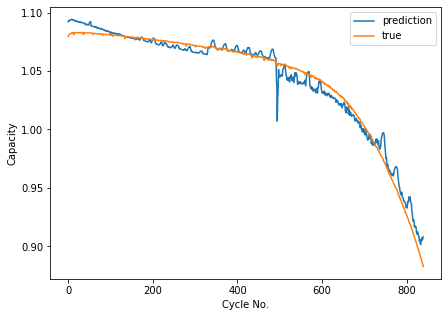

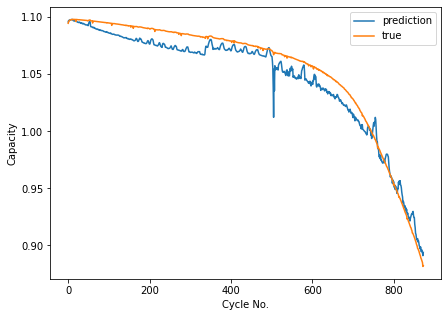

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# # Plot the capacity curve for cell 3 and predicted capacities for cell 3
# valid_nasa = CapacityDataset([nasa_data[3]], type='test', window=[25, 26], random=True)
# valid_mit = CapacityDataset([mit_data[4]], type='test', window=[25, 26],random=True)

# valid_loader_nasa = DataLoader(valid_nasa, batch_size=16,  shuffle=False)
# valid_loader_mit = DataLoader(valid_mit, batch_size=16, shuffle=False)

# test_mit = CapacityDataset([mit_data[5]], type='test', window=[25, 26], random=True)
# test_loader_mit = DataLoader(test_mit, batch_size=16, shuffle=False)


for loader, type in ([(valid_loader_c, "Valid MIT"), (test_loader_mit, "TEST MIT")]):
    print ("\n", type)
    preds = [best_model(x.float()) for x, _, in loader]
    y =  [x for _, x in loader]
    y = torch.cat(y).view(-1).detach().numpy()*1.1
    preds = torch.cat(preds).view(-1).detach().numpy()*1.1
    print (preds.shape, y.shape)
    plt.figure(figsize=(7, 5))
    plt.plot(np.arange(preds.shape[0]),preds,label="prediction")
    plt.plot(np.arange(preds.shape[0]),y,label="true")
    plt.xlabel('Cycle No.')
    plt.ylabel('Capacity')
    error_train_mape = mean_absolute_percentage_error(preds, y)
    error_train_rmse = mean_squared_error(preds, y)
    error_train_r2 = r2_score(preds, y)
    plt.legend()
    
    print(f"MAPE: {error_train_mape}" )
    print(f"RMSE : { error_train_rmse}")
    print(f"R2 Score : {error_train_r2}")